In [1]:
import collections
import numpy as np
import pandas as pd
import scipy.io as io
import ipyvolume as ipv
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

#### Notes:
- Mill -> Double Ring -> Flock
    - icR: 3, ilR: 3, iR: 1
    - data_long_3d_icR_3_ilR_3_cool_double_ring.mat
    - X, Y, Z range : (-1.5, 1.5)
- Mill -> Flocking mill
    - icR: 4, ilR: 2, iR: 1
    - data_long_3d_icR_4_ilR_2_single_mill_flock.mat
    - X, Y, Z range : (-2.5, 2.5)
- Mill -> Flocking mill
    - icR: 4, ilR: 1, iR: 1
    - data_3d_icR_4_ilR_1_iR_1.mat
    - X, Y, Z range : (-1, 1)
- Milling in groups
    - icR: 3, ilR: 2, iR: 5
    - data_3d_icR_3_ilR_2_iR_5.mat
    - X, Y, Z range : (-1, 1)
- Escape
    - In groups: data_3d_icR_5_ilR_2_iR_1.mat
    - Uniformly: data_3d_icR_5_ilR_4_iR_1.mat
    - X, Y, Z range : (-10, 10)

In [2]:
dr_filename = 'data_long_3d_icR_3_ilR_3_cool_double_ring.mat'
dr_mat = io.loadmat(dr_filename)

In [3]:
num_time_points = len(dr_mat['t'])
num_particles = dr_mat['N'][0][0]
num_cols = np.shape(dr_mat['z'])[1]

print 'Num time points: ' + repr(num_time_points)
print 'Num particles: ' + repr(num_particles)
print 'Data shape: ' + repr(np.shape(dr_mat['z']))

Num time points: 40001
Num particles: 200
Data shape: (40001, 1200)


In [4]:
particle_data = np.zeros((6, num_time_points, num_particles))

times_saved = []
cnt = 0

for i in range(0, len(dr_mat['t']), 5):
    
    particle_data[0, cnt, :] = dr_mat['z'][i][0:num_particles]
    particle_data[1, cnt, :] = dr_mat['z'][i][num_particles:2*num_particles]
    particle_data[2, cnt, :] = dr_mat['z'][i][2*num_particles:3*num_particles]
    
    particle_data[3, cnt, :] = dr_mat['z'][i][3*num_particles:4*num_particles]
    particle_data[4, cnt, :] = dr_mat['z'][i][4*num_particles:5*num_particles]
    particle_data[5, cnt, :] = dr_mat['z'][i][5*num_particles:6*num_particles]
    
    times_saved.append(i)
    cnt = cnt + 1

print len(times_saved)

8001


In [5]:
print times_saved[2500]

12500


In [6]:
fig = ipv.figure(width=900, height=800)
q = ipv.quiver(*particle_data[:,0:len(times_saved)-1,:], color="red", size=5)
ipv.style.use("dark")
ipv.animation_control(q, interval=300)
ipv.xyzlim(-1.5, 1.5)
ipv.show()

VkJveChjaGlsZHJlbj0oRmlndXJlKGFuaW1hdGlvbj0zMDAuMCwgYW5pbWF0aW9uX2V4cG9uZW50PTEuMCwgY2FtZXJhX2NlbnRlcj1bMC4wLCAwLjAsIDAuMF0sIGhlaWdodD04MDAsIG1hdHLigKY=


In [9]:
np.shape(particle_data)

(6, 40001, 200)

In [10]:
12500*0.05

625.0

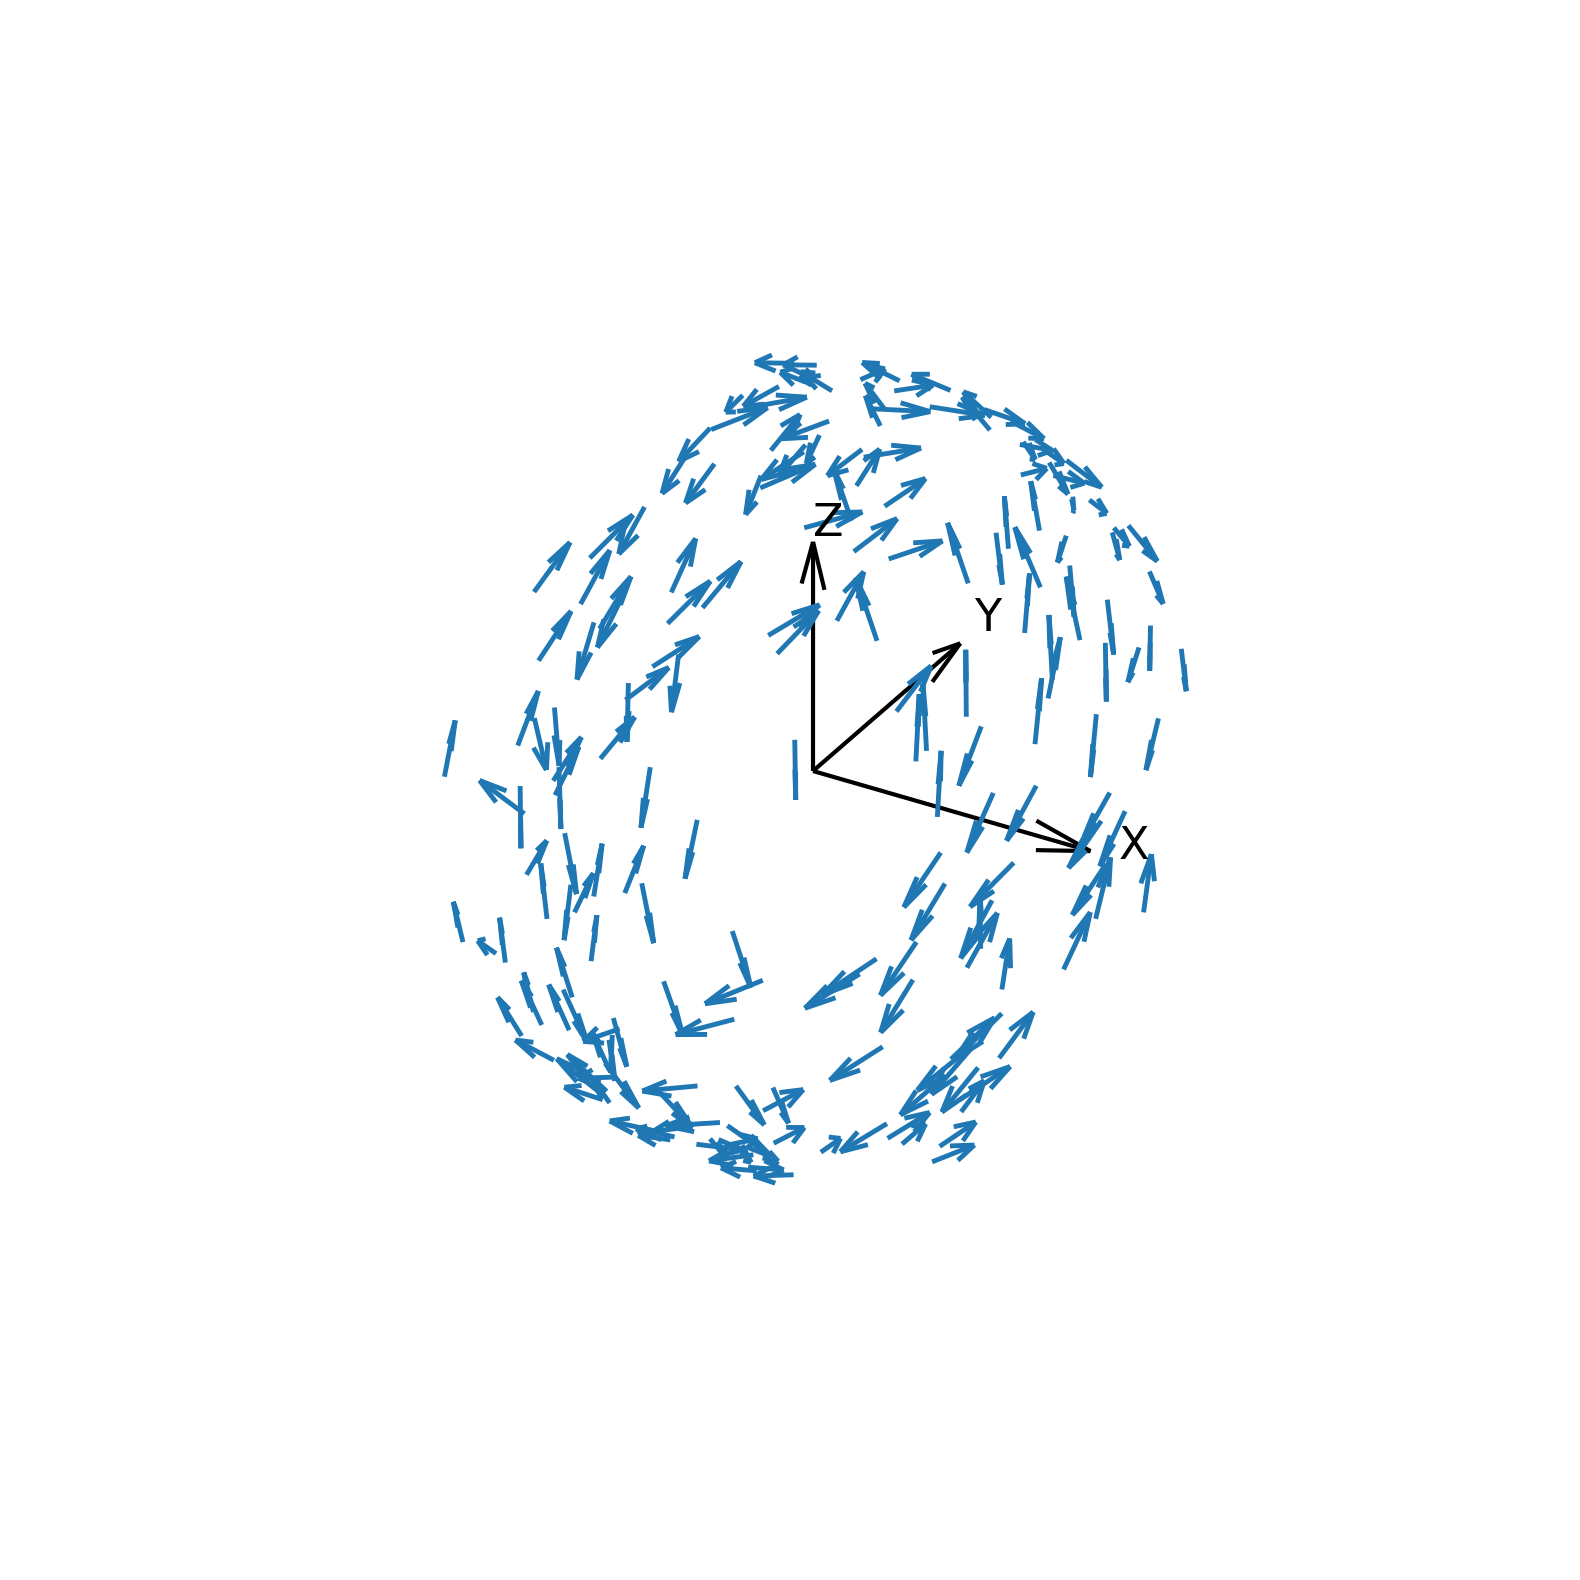

In [11]:
[xpos, ypos, zpos] = particle_data[0:3,2500,:]
[xpos_old, ypos_old, zpos_old] = particle_data[0:3,2500-5,:]
[xvel, yvel, zvel] = particle_data[3:6,2500,:]

x_cm = np.true_divide(np.sum(xpos), len(xpos))
y_cm = np.true_divide(np.sum(ypos), len(ypos))
z_cm = np.true_divide(np.sum(zpos), len(zpos))

fig = plt.figure(figsize=(8,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.quiver(xpos-x_cm, ypos-y_cm, zpos-z_cm, xvel, yvel, zvel, 
          length=0.1, linewidth=1.75, arrow_length_ratio=0.5, normalize=True)

x, y, z = np.array([[0,0,0],[0,0,0],[0,0,0]])
u, v, w = np.array([[0.5,0,0],[0,0.5,0],[0,0,0.4]])
ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.2, color="black")
ax.text(0.55, 0, 0, 'X', fontsize=16)
ax.text(0, 0.55, 0, 'Y', fontsize=16)
ax.text(0, 0, 0.41, 'Z', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('3dmodelsnapshot.png')
plt.show()

In [15]:
class CP_Data:
    
    def __init__(self, icR, ilR):
        self.icR = int(icR)
        self.ilR = int(ilR)
        self.feats = collections.defaultdict(list)
        
    def describe(self):
        print "icR: " + repr(self.icR) + " ilR: " + repr(self.ilR) + " nRs: " + repr(self.nRs)
        
    def add_rep_feats(self, nRep, df):
        self.feats[nRep] = df.as_matrix()
    
    def get_rep_feat(self, nRep):
        return self.feats[nRep]
    
    def get_sim_params(self):
        return (self.icR, self.ilR)
    
    def get_nreps(self):
        return self.nRs

In [16]:
def extract_feats(CP_List, icR, ilR, nRep):
    for CP_Data in CP_List:
        if (icR, ilR) == CP_Data.get_sim_params():
            feat_data = np.transpose(CP_Data.get_rep_feat(nRep))
            feat_dict = {}
            for ind in range(len(feat_data)):
                feat_dict[str(feat_data[ind][0])] = feat_data[ind][1:]
            return feat_dict

In [17]:
Crocker_Full_Data_List = list()
Crocker_Full_Data_List.append(CP_Data(3,3))

df = pd.read_csv('data_long_3d_icR_3_ilR_3_cool_double_ring_CD_pos_td.csv', header=None)
Crocker_Full_Data_List[-1].add_rep_feats(1, df)

In [18]:
feat_dict = extract_feats(Crocker_Full_Data_List, 3, 3, 1)

print feat_dict.keys()
eps_vals = list(np.unique(map(float, feat_dict['epsilon'])))
dim_vals = list(np.unique(map(int, feat_dict['dimension'])))

['epsilon', 'dimension', 't', 'betticount', 'n']


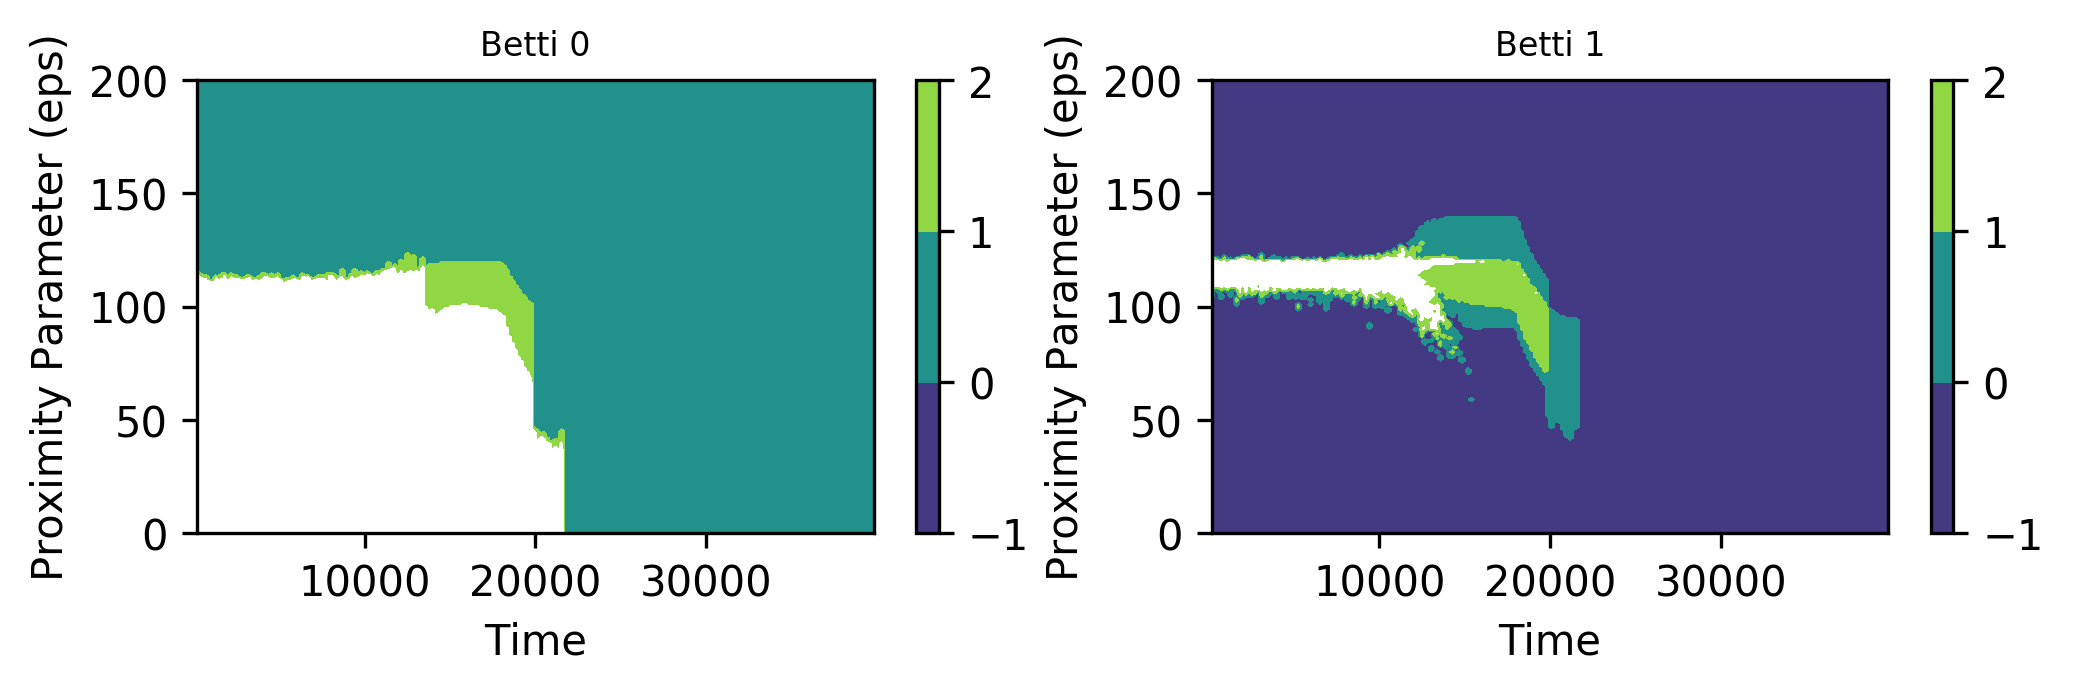

In [19]:
time_vals = np.unique(map(int, feat_dict['t']))
pers_homology = list(map(int, feat_dict['betticount']))

delta_eps = 1e-4
eps_max = int(np.max(eps_vals))
eps_min = int(np.min(eps_vals))
eps_log_vals = np.logspace(-4, 0, num = 200)
eps_log_vals = np.insert(eps_log_vals, 0, 0)

delta_t = time_vals[1] - time_vals[0]
t_max = int(np.max(time_vals))
t_min = int(np.min(time_vals))

betti_0_mat = np.zeros((len(time_vals), len(eps_vals)))
betti_1_mat = np.zeros((len(time_vals), len(eps_vals)))

def get_common_indices(listA, listB):
    res = list()
    for x in listA:
        if x in listB:
            res.append(x)
    return res

cnt = 0
for t_val in time_vals:
    
    time_idx = np.where(list(map(int, feat_dict['t'])) == t_val)[0]   
    dim_0_idx = np.where(list(map(int, feat_dict['dimension'])) == dim_vals[0])[0]
    dim_1_idx = np.where(list(map(int, feat_dict['dimension'])) == dim_vals[1])[0]
    
    idx_0 = get_common_indices(time_idx, dim_0_idx)
    idx_1 = get_common_indices(time_idx, dim_1_idx)
    
    betti_0_mat[cnt, :] = [pers_homology[idx] for idx in idx_0]
    betti_1_mat[cnt, :] = [pers_homology[idx] for idx in idx_1]
    cnt += 1
    
X, Y = np.mgrid[t_min:t_max+1:delta_t, 0:200:1]

fig, axes = plt.subplots(1, 2, figsize=(8,2), dpi=300)

c0 = axes[0].contourf(X, Y, betti_0_mat, levels=[-1.0, 0.0, 1.0, 2.0])
axes[0].set_ylim([0, 200])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Proximity Parameter (eps)')
axes[0].set_title('Betti 0', fontsize=8)
plt.colorbar(c0, ax=axes[0])

#range(1,int(np.amax(betti_0_mat))+1)

c1 = axes[1].contourf(X, Y, betti_1_mat, levels=[-1.0, 0.0, 1.0, 2.0])
axes[1].set_ylim([0, 200])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Proximity Parameter (eps)')
axes[1].set_title('Betti 1', fontsize=8)
plt.colorbar(c1, ax=axes[1])

plt.savefig('data_long_3d_icR_3_ilR_3_cool_double_ring_CROCKER_td.png')

In [20]:
Crocker_Full_Data_List = list()
Crocker_Full_Data_List.append(CP_Data(3,3))

df = pd.read_csv('data_long_3d_icR_3_ilR_3_cool_double_ring_CD_pos_vel.csv', header=None)
Crocker_Full_Data_List[-1].add_rep_feats(1, df)

In [21]:
feat_dict = extract_feats(Crocker_Full_Data_List, 3, 3, 1)

print feat_dict.keys()
eps_vals = list(np.unique(map(float, feat_dict['epsilon'])))
dim_vals = list(np.unique(map(int, feat_dict['dimension'])))

['epsilon', 'dimension', 't', 'betticount', 'n']


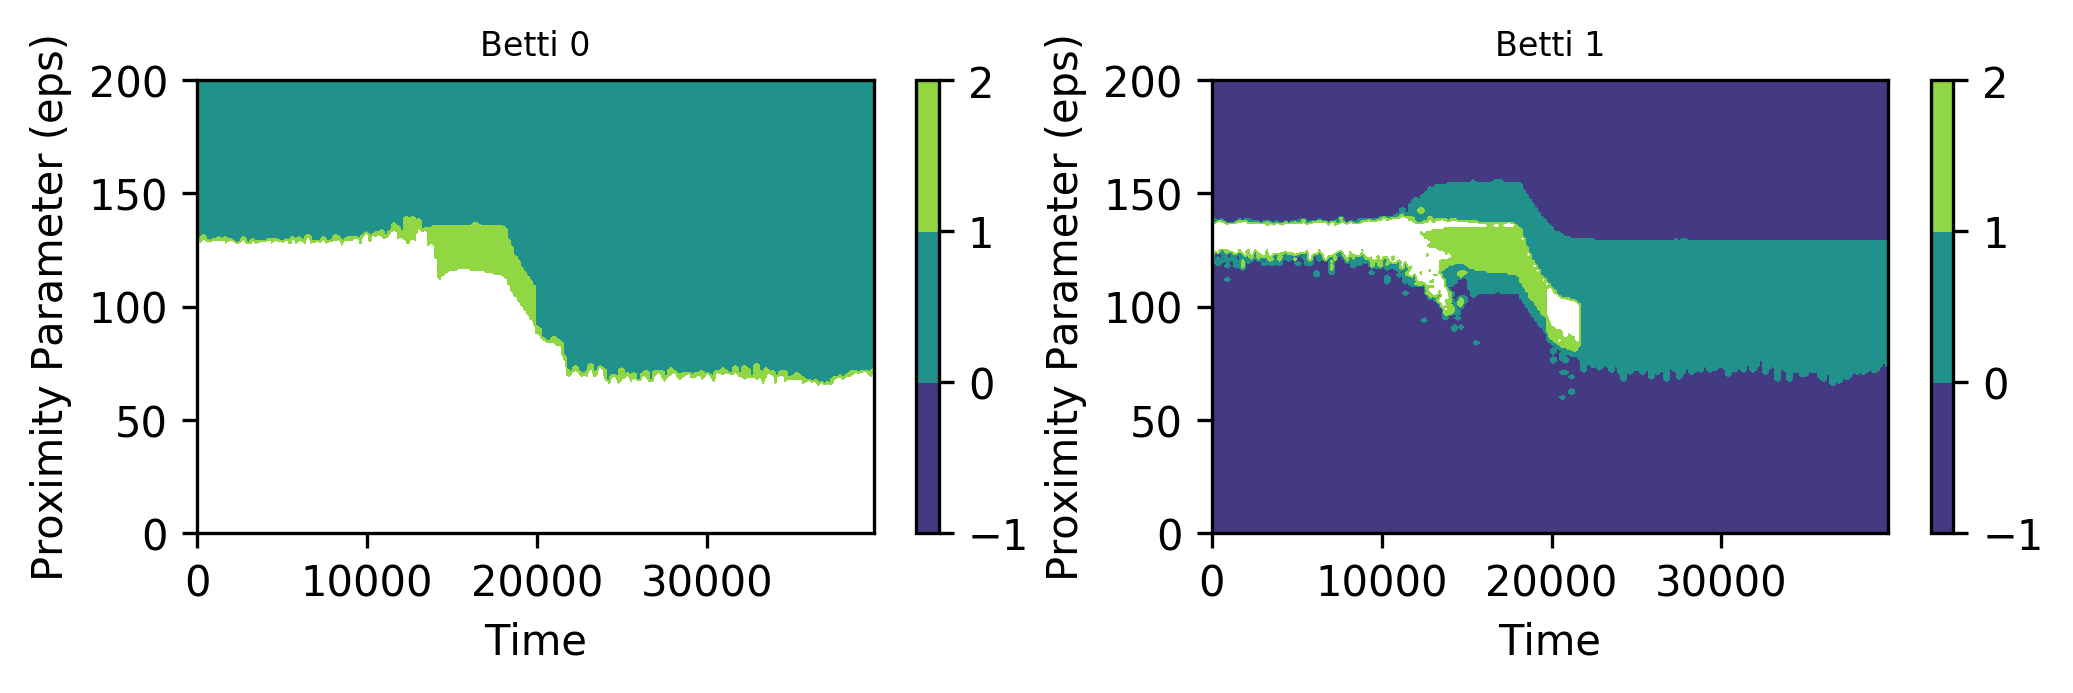

In [23]:
time_vals = np.unique(map(int, feat_dict['t']))
pers_homology = list(map(int, feat_dict['betticount']))

delta_eps = 1e-4
eps_max = int(np.max(eps_vals))
eps_min = int(np.min(eps_vals))
eps_log_vals = np.logspace(-4, 0, num = 200)
eps_log_vals = np.insert(eps_log_vals, 0, 0)

delta_t = time_vals[1] - time_vals[0]
t_max = int(np.max(time_vals))
t_min = int(np.min(time_vals))

betti_0_mat = np.zeros((len(time_vals), len(eps_vals)))
betti_1_mat = np.zeros((len(time_vals), len(eps_vals)))

def get_common_indices(listA, listB):
    res = list()
    for x in listA:
        if x in listB:
            res.append(x)
    return res

cnt = 0
for t_val in time_vals:
    
    time_idx = np.where(list(map(int, feat_dict['t'])) == t_val)[0]   
    dim_0_idx = np.where(list(map(int, feat_dict['dimension'])) == dim_vals[0])[0]
    dim_1_idx = np.where(list(map(int, feat_dict['dimension'])) == dim_vals[1])[0]
    
    idx_0 = get_common_indices(time_idx, dim_0_idx)
    idx_1 = get_common_indices(time_idx, dim_1_idx)
    
    betti_0_mat[cnt, :] = [pers_homology[idx] for idx in idx_0]
    betti_1_mat[cnt, :] = [pers_homology[idx] for idx in idx_1]
    cnt += 1
    
X, Y = np.mgrid[t_min:t_max+1:delta_t, 0:200:1]

fig, axes = plt.subplots(1, 2, figsize=(8,2), dpi=300)

c0 = axes[0].contourf(X, Y, betti_0_mat, levels=[-1.0, 0.0, 1.0, 2.0])
axes[0].set_ylim([0, 200])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Proximity Parameter (eps)')
axes[0].set_title('Betti 0', fontsize=8)
plt.colorbar(c0, ax=axes[0])

#range(1,int(np.amax(betti_0_mat))+1)

c1 = axes[1].contourf(X, Y, betti_1_mat, levels=[-1.0, 0.0, 1.0, 2.0])
axes[1].set_ylim([0, 200])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Proximity Parameter (eps)')
axes[1].set_title('Betti 1', fontsize=8)
plt.colorbar(c1, ax=axes[1])

plt.savefig('data_long_3d_icR_3_ilR_3_cool_double_ring_CROCKER_posvel.png')

In [24]:
np.round([eps_log_vals[50], eps_log_vals[100], eps_log_vals[150], eps_log_vals[200]], 4)

array([0.001 , 0.0098, 0.0988, 1.    ])